## Implementation of U-Net model for a semantic segmentation task

(Pratichhya Sharma-CDE)

I used the dataset provided to me at the University of Salzburg during a specific course for academic purpose only, from which I have performed Semantic Segmentation of Buildings in the image using a simple U-Net model.

In [2]:
#importing necessary packages
import rasterio
import numpy as np
import matplotlib.pyplot as plt

from skimage import exposure
import matplotlib.patches as mpatches

## Loading the dataset

In [3]:
Xtrain_main = rasterio.open('Xtrain.tif').read()
Ytrain_main = rasterio.open('Ytrain.tif').read()
Xtest_main = rasterio.open('Xtest.tif').read()
Ytest_main = rasterio.open('Ytest_v2.tif').read()

In [4]:
print("shape of Xtrain: ", Xtrain_main.shape)
print("shape of Ytrain: ", Ytrain_main.shape)
print("shape of Xtest: ", Xtest_main.shape)
print("shape of Ytest: ", Ytest_main.shape)  #need to remake the dataset

shape of Xtrain:  (4, 1953, 2161)
shape of Ytrain:  (1, 1953, 2161)
shape of Xtest:  (4, 461, 490)
shape of Ytest:  (1, 461, 490)


/tmp/ipykernel_599/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


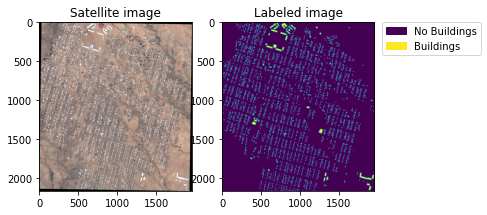

In [5]:
#Visualize the data

def visualize_data(data,data2):
    f, axarr = plt.subplots(1,2)
    data = data[:, :, 0:3]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    axarr[0].imshow(data)
    axarr[0].set_title("Satellite image")

    a=axarr[1]
    values = np.unique(data2.ravel())
    im = axarr[1].imshow(data2[:,:,0])
    a.set_title("Labeled image")
    colors = [im.cmap(im.norm(value)) for value in values] 
    data2 = ["No Buildings", "Buildings"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), data2)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

visualize_data(Xtrain_main.swapaxes(0,2),Ytrain_main.swapaxes(0,2)) #Visualize Images Side by Side

## Image Patching

Instead of random patching, here we are creating patches from entire dataset as we lack enough dataset.

In [6]:
PATCHSIZE = 128
NBANDS = Xtrain_main.shape[0]

def gridwise_sample(imgarray, patchsize):
    ''' to make a grid of 256x256 on top of the image and create sample patches '''
    nbands,nrows, ncols = imgarray.shape
    patchsamples = np.zeros(shape=(0, nbands,patchsize, patchsize),
                            dtype=imgarray.dtype)
    
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[:,i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

In [7]:
Xtrain = gridwise_sample(Xtrain_main, PATCHSIZE)
Ytrain = gridwise_sample(Ytrain_main, PATCHSIZE)
print("There are %i number of training patches" % (Xtrain.shape[0]))

There are 240 number of training patches


## Augmentation
Since there are fewer number of samples lets do the augmentation on Flip and Mirror

In [8]:
#image filpping
Xtrain_fliped = Xtrain[:,:,::-1, :]
Xtrain_mirrored = Xtrain[:,:,:,::-1]

#image mirroring
Ytrain_fliped = Ytrain[:,:,::-1, :]
Ytrain_mirrored = Ytrain[:,:,:,::-1]

In [9]:
Xtrain.shape,Ytrain.shape

((240, 4, 128, 128), (240, 1, 128, 128))

/tmp/ipykernel_599/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


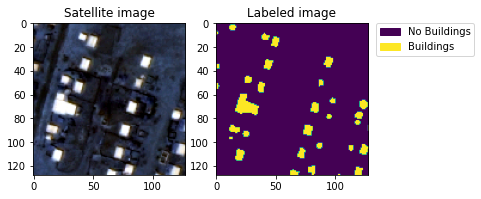

In [10]:
visualize_data(Xtrain[40].swapaxes(0,2),Ytrain[40].swapaxes(0,2))

/tmp/ipykernel_599/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


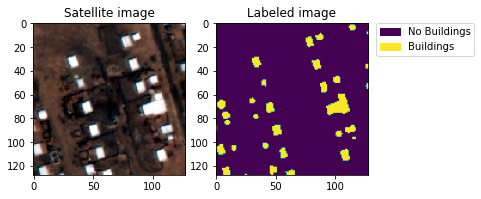

In [11]:
visualize_data(Xtrain_fliped[40].swapaxes(0,2),Ytrain_fliped[40].swapaxes(0,2))

/tmp/ipykernel_599/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


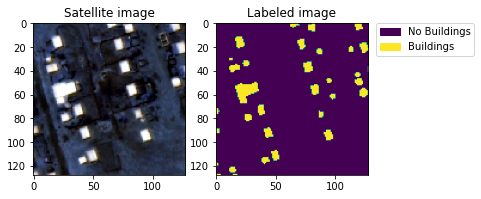

In [12]:
visualize_data(Xtrain_mirrored[40].swapaxes(0,2),Ytrain_mirrored[40].swapaxes(0,2))

In [13]:
#Lets append the datasets
Xtrain_fliped=np.append(Xtrain,Xtrain_fliped,axis=0)
Xtrain=np.append(Xtrain_fliped,Xtrain_mirrored,axis=0)
Ytrain_fliped=np.append(Ytrain,Ytrain_fliped,axis=0)
Ytrain=np.append(Ytrain_fliped,Ytrain_mirrored,axis=0)

In [14]:
Ytrain.shape

(720, 1, 128, 128)

## One hot Encoding
The Ytrain dataset only have 1 band which includes 0 for no buildings and 1 for buildings, so lets make it one hot encoding. In this case we will have to change 0 to [1,0] and 1 to [0,1]

In [15]:
ones=np.ones(Ytrain.shape)
ytrain_inverted=ones-Ytrain # Because 1-0 is 1 and 1-0 is zero
Ytrain=np.concatenate((ytrain_inverted,Ytrain),axis=1)
Ytrain.shape

(720, 2, 128, 128)

## convert to pytorch dataset
Lets convert the numpy array to pytorch datset

In [16]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.Tensor(Xtrain) 
tensor_y = torch.Tensor(Ytrain)

tensor_dataset = TensorDataset(tensor_x,tensor_y) 
train_data = DataLoader(tensor_dataset) 

## Define the network
Lets define the famous UNET model for segmentation of buildings. The model is modified from https://github.com/milesial/Pytorch-UNet The Architecture of UNET is like this:
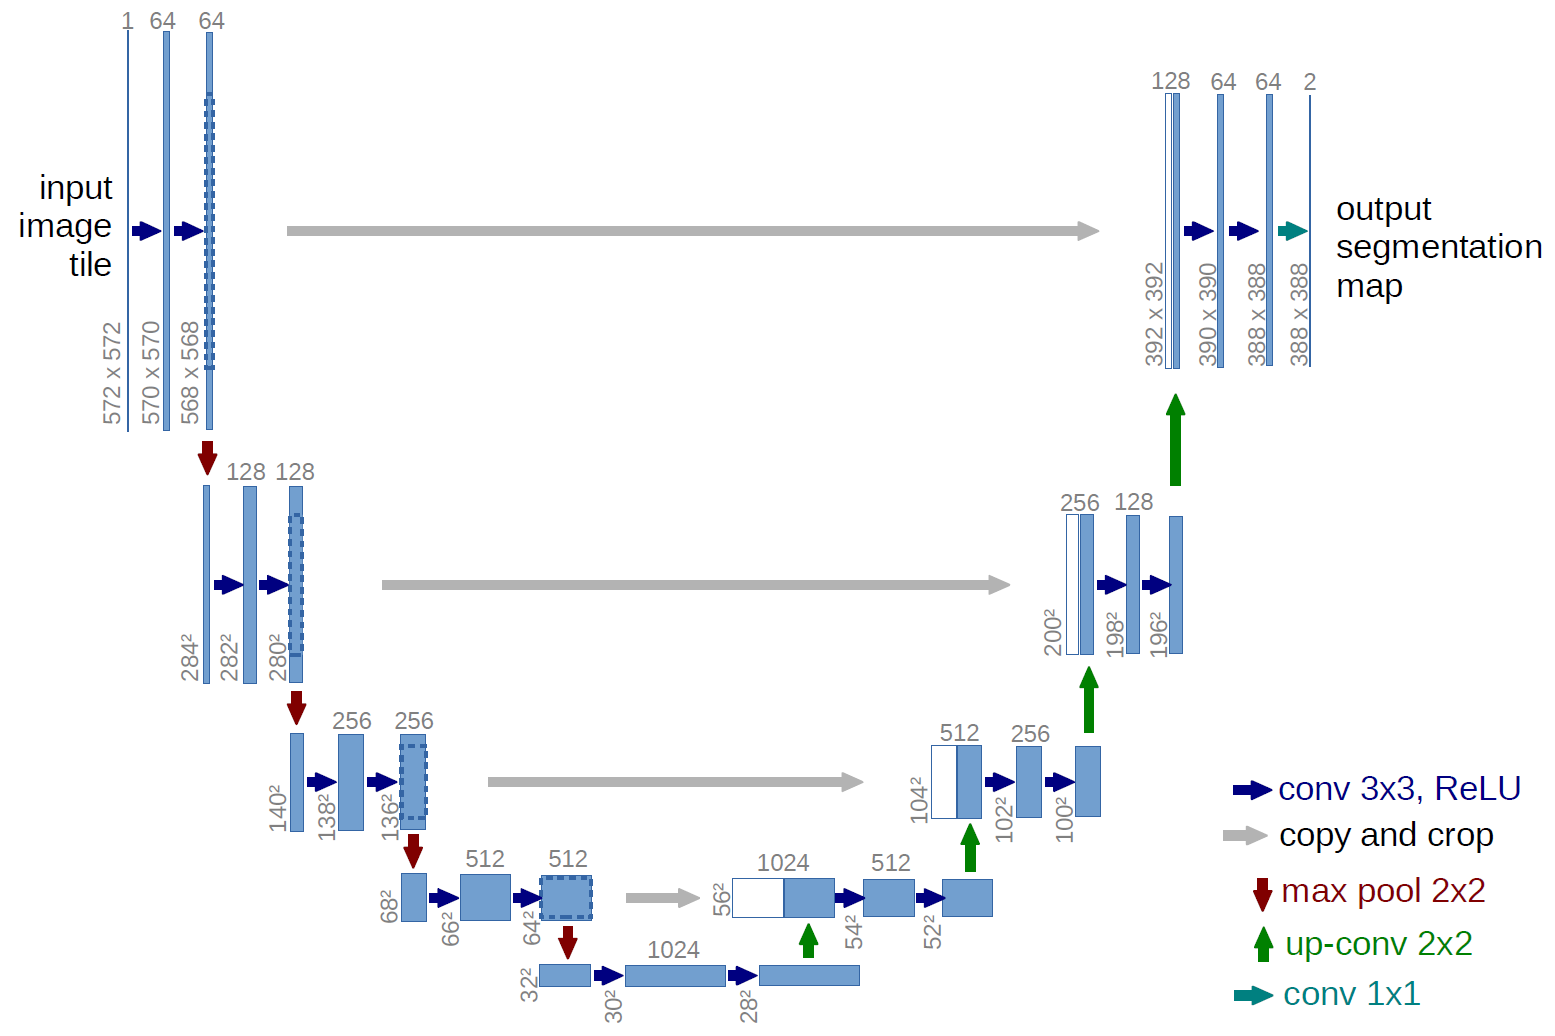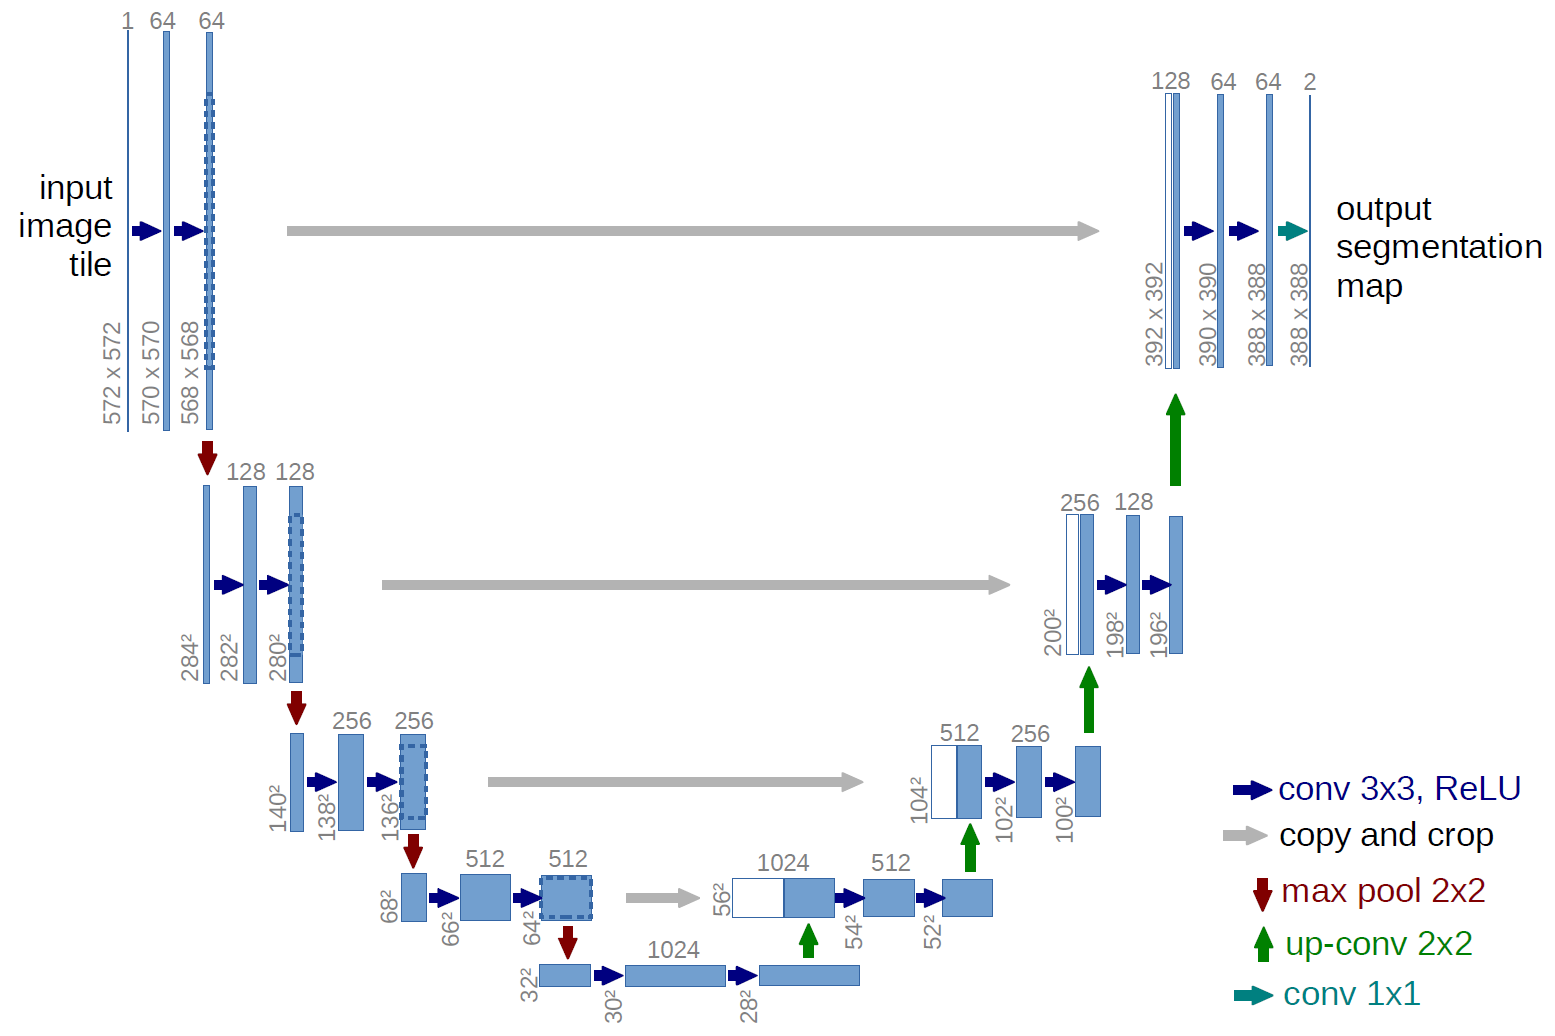

In [17]:
""" Defining Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [18]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [19]:
net = UNet(n_channels=4, n_classes=2, bilinear=True)
net.cuda()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [20]:
from torchsummary import summary
summary(net,input_size=( 4,128, 128),batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 128, 128]           2,304
       BatchNorm2d-2          [1, 64, 128, 128]             128
              ReLU-3          [1, 64, 128, 128]               0
            Conv2d-4          [1, 64, 128, 128]          36,864
       BatchNorm2d-5          [1, 64, 128, 128]             128
              ReLU-6          [1, 64, 128, 128]               0
        DoubleConv-7          [1, 64, 128, 128]               0
         MaxPool2d-8            [1, 64, 64, 64]               0
            Conv2d-9           [1, 128, 64, 64]          73,728
      BatchNorm2d-10           [1, 128, 64, 64]             256
             ReLU-11           [1, 128, 64, 64]               0
           Conv2d-12           [1, 128, 64, 64]         147,456
      BatchNorm2d-13           [1, 128, 64, 64]             256
             ReLU-14           [1, 128,

## Design the optimizer

In [21]:

base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

In [1]:
from IPython.display import clear_output
import torchmetrics
def train(net, optimizer, epochs, scheduler=None, save_epoch = 5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    running_loss = 0.
    last_loss = 0.
    loss_fn=torch.nn.CrossEntropyLoss()
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        
        
        for batch_idx, (data,target) in enumerate(train_data):
            data,target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            #print(inputs.cpu().numpy().shape)
            output = net(data)
            
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
        
            losses[iter_] = loss.item() ##loss.data[0]
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = np.argmax(target.data.cpu().numpy()[0],axis=0)
                print(pred.shape,gt.shape)
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_data),
                    100. * batch_idx / len(train_data), loss.item(), accuracy(pred, gt))) ##loss.data[0]
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(gt)
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(pred)
                plt.show()
            iter_ += 1

            del(data, target, loss)
    torch.save(net.state_dict(), './unet_final')


(128, 128) (128, 128)
Train (epoch 3/5) [560/720 (78%)]	Loss: 0.103600	Accuracy: 95.770263671875


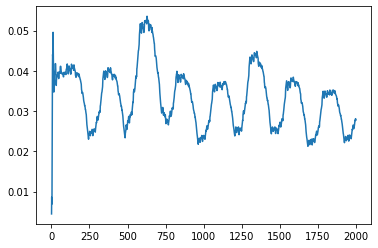

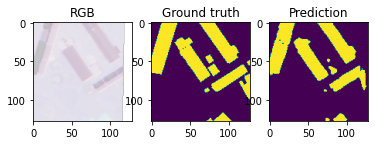

KeyboardInterrupt: 

In [27]:
import wandb
wandb.login()
wandb.init(project="Unet_test")
train(net, optimizer, 5, scheduler)
wandb.log({'accuracy': accuracy, 'loss': losses})

(128, 128) (128, 128)
Train (epoch 4/5) [440/720 (61%)]	Loss: 0.009914	Accuracy: 99.761962890625


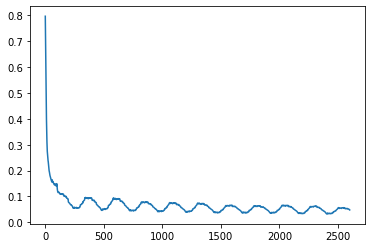

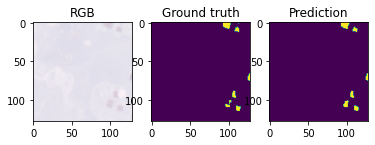

KeyboardInterrupt: 

In [25]:
train(net, optimizer, 5, scheduler)

# TEST


## Prepare Test Data

In [ ]:
#Visualize the data
visualize_data(Xtest_main.swapaxes(0,2),Ytest_main.swapaxes(0,2)) #Visualize Images Side by Side

In [ ]:
#creating test dataset patches
Xtest = gridwise_sample(Xtest_main, PATCHSIZE)
Ytest = gridwise_sample(Ytest_main, PATCHSIZE)
print("There are %i number of training patches" % (Xtest.shape[0]))

In [ ]:
#one hot encoding on test dataset
ones=np.ones(Ytest.shape)
ytest_inverted=ones-Ytest # Because 1-0 is 1 and 1-0 is zero
Ytest=np.concatenate((ytest_inverted,Ytest),axis=1)
Ytest.shape

In [ ]:
#converting to tensor
tensor_x = torch.Tensor(Xtest) 
tensor_y = torch.Tensor(Ytest)

tensor_dataset = TensorDataset(tensor_x,tensor_y) 
test_data = DataLoader(tensor_dataset) 

In [ ]:
# Utils
LABELS=['No Buildings','Buildings']

from sklearn.metrics import confusion_matrix

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            labels=range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

In [ ]:
def test():
    all_preds = []
    all_gts = []
    all_acs=[]
    net.eval()
    for test_idx, (data,target) in enumerate(test_data):
        print(f'--------------Testing on patch number: {test_idx+1}----------------- ')
        data,target = Variable(data.cuda()), Variable(target.cuda())
        output = net(data)

        pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
        gt = np.argmax(target.data.cpu().numpy()[0],axis=0)

        # Display the result
        rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
        fig = plt.figure()
        fig.add_subplot(131)
        plt.imshow(rgb)
        plt.title('RGB')
        fig.add_subplot(132)
        plt.imshow(gt)
        plt.title('Ground truth')
        fig.add_subplot(133)
        plt.title('Prediction')
        plt.imshow(pred)
        plt.show()
        all_preds.append(pred)
        all_gts.append(gt)
        #return pred.ravel(),gt_e.ravel()
        # Compute some metrics
        metrics(pred.ravel(), gt.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
        all_acs.append(accuracy)
    print(f'--------------Overall Accuracy: ----------------- ')
    print(f'Mean accuracy in test set is: {sum(all_acs) / len(all_acs)}')
    return all_acs

In [ ]:
test()